# Gibbs chain verification

In [45]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [46]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_LiteBIRD_64 import *

In [47]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


# Studying the sampling !

In [48]:
sub_step_sampling = 50
file_ver = 'biased_masked_full_v94_Gchain_SO_64_v1a' # -> 3000 iterations + mask + 10% error + biased_full_chain_v1a ; C_approx only lensing
path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
# file_ver = 'biased_unmasked_full_v100_Gchain_SO_64_v0a' # -> 3000 iterations + unmask + 10% error + biased_full_chain_v1a ; C_approx only lensing
# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
# file_ver = 'biased_masked_full_v100_Gchain_SO_64_v1b' # -> NOT CHEAP ! 100 iterations + mask + 10% error + biased_full_chain_v1b ; C_approx only lensing
# path_toml_file = directory_toml_file + 'biased_full_chain_v1b.toml'
# sub_step_sampling = 1
# file_ver = 'biased_masked_full_v100_Gchain_SO_64_v1c' # -> WF masked ! + 2500 iterations + mask + 1% error + biased_full_chain_v1c ; C_approx only lensing
# path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'
file_ver = 'biased_masked_full_v100_Gchain_SO_64_v1d' # -> WF&Fluct v2 + 2500 iterations + mask + 1% error + biased_full_chain_v1c ; C_approx only lensing
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'
### Good run !!!

# file_ver = 'Iwish_biased_unmasked_full_v100_Gchain_SO_64_v1a' # -> 4000 iterations + no B_f/eta + unmask + Iwish_biased_full_chain_v1a ; C_approx only lensing ;; LIMIT_ITER = 10 ????
# path_toml_file = directory_toml_file + 'Iwish_biased_full_chain_v1a.toml'
file_ver = 'corr_masked_full_v100_Gchain_SO_64_v1a' # -> WF&Fluct v2 + 2500 iterations + 100 limit_iter + mask + 1% error + corr_full_chain_v1a ; C_approx only lensing
path_toml_file = directory_toml_file + 'corr_full_chain_v1a.toml'
# sub_step_sampling = 1
file_ver = 'corr_masked_full_v100_Gchain_SO_64_v1b' # -> WF&Fluct v2 + 1000 iterations + 200 limit_iter + mask + 1% error + corr_full_chain_v1b ; C_approx only lensing
path_toml_file = directory_toml_file + 'corr_full_chain_v1b.toml'
file_ver = 'corr_masked_full_v100_Gchain_SO_64_v1c' # -> WF&Fluct v2 + 1500 iterations + restrict_to_mask + 50 limit_iter_eta + mask + 1% error + corr_full_chain_v1c ; C_approx only lensing
path_toml_file = directory_toml_file + 'corr_full_chain_v1c.toml'
file_ver = 'Iwish_biased_unmasked_full_v100_Gchain_SO_64_v2a' # -> 2000 iterations + no B_f/eta + unmask + Iwish_biased_full_chain_v1b ; C_approx only lensing
path_toml_file = directory_toml_file + 'Iwish_biased_full_chain_v1b.toml'


In [49]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [50]:
if (MICMAC_sampler_obj.number_iterations_sampling > 100) and (sub_step_sampling==1):
    sub_step_sampling = 50
elif MICMAC_sampler_obj.number_iterations_sampling > 1000:
    sub_step_sampling = 100

In [51]:
reduction_noise = 1

In [52]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [53]:
# input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# # input_cmb_maps = input_cmb_maps_alt
# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')
# freq_maps = input_cmb_maps + freq_maps_fgs
# freq_maps = np.load(directory_save_file+file_ver+'_initial_data.npy')


Calculating spectra from CAMB !


Calculating spectra from CAMB !


In [54]:
initial_freq_maps_path = directory_save_file+file_ver+'_initial_data.npy'
initial_freq_maps = np.load(initial_freq_maps_path)

initial_cmb_maps_path = directory_save_file+file_ver+'_initial_cmb_data.npy'
input_cmb_maps = np.load(initial_cmb_maps_path)
if not(MICMAC_sampler_obj.cheap_save):
    all_eta_maps_path = directory_save_file+file_ver+'_all_eta_maps.npy'
    all_eta_maps = np.load(all_eta_maps_path)

    all_s_c_WF_maps_path = directory_save_file+file_ver+'_all_s_c_WF_maps.npy'
    all_s_c_WF_maps = np.load(all_s_c_WF_maps_path)

    all_s_c_fluct_maps_path = directory_save_file+file_ver+'_all_s_c_fluct_maps.npy'
    all_s_c_fluct_maps = np.load(all_s_c_fluct_maps_path)


elif not(MICMAC_sampler_obj.very_cheap_save):
    all_s_c_path = directory_save_file+file_ver+'_all_s_c.npy'
    all_s_c_samples = np.load(all_s_c_path)
if MICMAC_sampler_obj.sample_r_Metropolis:
    all_r_samples_path = directory_save_file+file_ver+'_all_r_samples.npy'
    all_r_samples = np.load(all_r_samples_path)
elif MICMAC_sampler_obj.sample_C_inv_Wishart:
    all_cell_samples_path = directory_save_file+file_ver+'_all_cell_samples.npy'
    all_cell_samples = np.load(all_cell_samples_path)

all_params_mixing_matrix_samples_path = directory_save_file+file_ver+'_all_params_mixing_matrix_samples.npy'
all_params_mixing_matrix_samples = np.load(all_params_mixing_matrix_samples_path)


In [55]:
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens_synchdust.txt'
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/fisher_so-sat_d0s0_lmin2_lmax128_nomask_Alens1.0_r0.0_B_noiselens.txt'
# Fisher_matrix = np.loadtxt(path_Fisher)

# minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
# minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)
# print(minimum_std_Fisher_diag)

In [56]:
path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'

Fisher_matrix = np.loadtxt(path_Fisher)

jnp.array(jnp.diag(jsp.linalg.sqrtm(np.linalg.inv(Fisher_matrix))), dtype=jnp.float64)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2073: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


Array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04], dtype=float64)

In [57]:
jnp.sqrt(jnp.diag(np.linalg.inv(Fisher_matrix)))

Array([1.25494882e-04, 6.00826289e-05, 5.79540975e-05, 5.83047851e-05,
       4.71280947e-05, 2.08496542e-05, 2.02209488e-05, 2.13956700e-05,
       5.55036342e-04], dtype=float64)

In [58]:

# Getting C_approx and a first guess for C
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])

c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]


# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)
number_steps_sampler = 100


# Noise initialization
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [59]:
number_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [60]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter

## Testing $\eta$

In [61]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

In [62]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

red_cl_noise_harm = np.zeros_like(red_cov_approx_matrix)
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

        cl_noise = BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2
        red_cl_noise_harm[:] = np.diag([cl_noise,cl_noise])
        full_cl_noise = np.zeros_like(c_ell_approx)
        full_cl_noise[:MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.lmin:] = cl_noise

        # analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
        analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

        # analytical_eta_term = np.zeros_like(c_ell_approx)
        analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]

        eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[iteration,0,...]), all_eta_maps[iteration]])
        c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(7,5))
        plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            ax = plt.subplot(311+j)
            plt.title(list_correl[j])
            
            plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')

            plt.plot(ell_arange, c_ell_approx[j,MICMAC_sampler_obj.lmin:], label='c_ell_approx')
            # plt.plot(ell_arange, full_cl_noise[j,MICMAC_sampler_obj.lmin:], label='c_ell N_c')
            plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")

            plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

            if MICMAC_sampler_obj.nstokes == 3 and j < number_correl_to_plot-2:
                plt.xticks(color='w')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                # plt.ylim(ymin=noise_level/10.)
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.legend()
            if j == position_legend:
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            
            plt.ylabel("$C_\ell$ [$uK^2$]")
            if j == number_correl_to_plot-1:
                plt.xlabel(r"$\ell$")
        plt.show()

# Validation $s_c$

In [63]:
all_params_mixing_matrix_samples[0].ravel(order='F').reshape((4,2),order='F')

array([[0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761]])

In [64]:
# [[0.33858815 0.00979233]
#  [0.02963068 0.05147511]
#  [0.00998213 0.12913911]
#  [0.00328725 0.44076761]]

In [65]:
initial_freq_maps.shape

(6, 2, 49152)

In [66]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        
        if MICMAC_sampler_obj.sample_r_Metropolis:
            red_cov_matrix = theoretical_red_cov_r0_total + all_r_samples[iteration]*theoretical_red_cov_r1_tensor
        elif MICMAC_sampler_obj.sample_C_inv_Wishart:
            red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
            if iteration != 0:
                red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                            analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(14,8))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(331+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('WF term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()

            plt.subplot(332+3*j)
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Fluctuation term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()
            
            plt.subplot(333+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")

            plt.xlabel(r"$\ell$")
            plt.legend()
        plt.show()

In [67]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.very_cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        

        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
        #                                                                     analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        # analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        # analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        # analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        # s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        # c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        # c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        # s_c_recovered = all_s_c_samples[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(10,5))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(311+j)
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            
            plt.xlabel(r"$\ell$")
            


        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


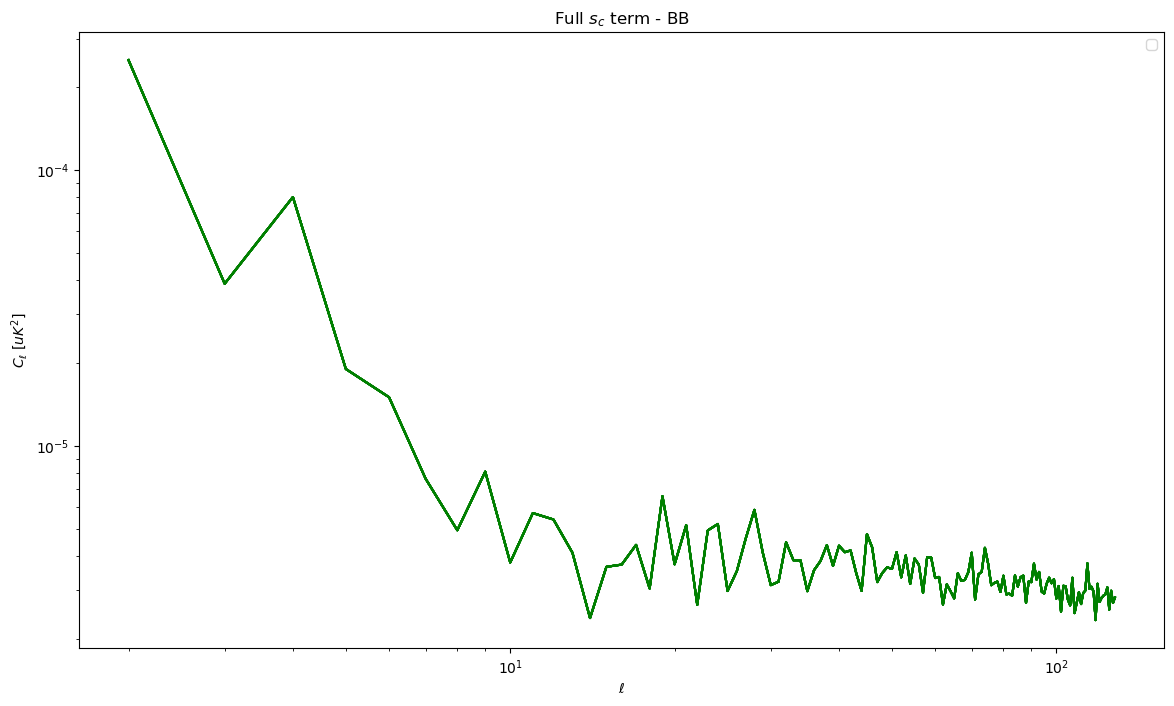

In [68]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

plt.figure(figsize=(14,8))
for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[MICMAC_sampler_obj.lmin:]
    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    if iteration != 0:
        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]

    # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
    # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
    # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

    # analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
    # analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
    # analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

    # s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
    # c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
    # c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
    # s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
    # s_c_recovered = all_s_c_samples[iteration,...]
    # s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
    # c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # plt.figure(figsize=(14,8))
    # plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

    # for j in range(number_correl_to_plot):
        # plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
        # plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ell_s_cML.shape[-1])+lmin, c_ell_s_cML[1,:], 'g', alpha=.5)

# if j <= nstokes-1:
#     plt.loglog()
#     plt.plot([lmin,lmax+1], [0,0], 'k:')
# else:
#     plt.xscale('log')
#     plt.yscale('symlog')
#     plt.plot([lmin,lmax+1], [0,0], 'k:')
plt.title('Full $s_c$ term - {}'.format(list_correl[1]))
plt.ylabel("$C_\ell$ [$uK^2$]")
plt.xlabel(r"$\ell$")
plt.loglog()
plt.legend()


plt.show()

# Plot $C$

In [69]:
# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

In [70]:
# list_correl = ['EE', 'BB', 'EB']

# ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
# min_value_mean = 3
# factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

# for iteration in range(0,number_iterations_sampling,sub_step_sampling):
#     covariance_noise = np.zeros_like(c_ell_approx)

#     mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
#     mixing_matrix_sampled = mixing_matrix_obj.get_B()
#     BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
#     BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
#     BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
#     s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
#     full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
#     # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]

#     full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
#     c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

#     full_map_s_c_extended = np.vstack([np.zeros_like(full_map_s_c[0,...]), full_map_s_c])
#     c_ell_s_c = hp.anafast(full_map_s_c_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

#     plt.figure(figsize=(10,5))
#     plt.suptitle(r"Little study $C$ for iteration {}".format(iteration))

#     for j in range(number_correl_to_plot):
#         ax = plt.subplot(311+j)
#         plt.title(list_correl[j])

#         plt.plot(ell_arange[min_value_mean:], c_ell_s_c[j,min_value_mean:]*factor_mean, label='Mean value invWishart')
#         plt.plot(ell_arange, c_ell_s_cML[j,...], label='$s_{c,ML}$')
#         plt.plot(ell_arange, all_cell_samples[iteration,j,lmin:], '--', label='Sample C')
#         plt.plot(ell_arange, c_ell_true_CMB[j,...], ':', label='True CMB')
        
#         plt.ylabel("$C_\ell$ [$uK^2$]")
#         if j == number_correl_to_plot-1:
#             plt.xlabel(r"$\ell$")
#             plt.legend()
#             plt.xscale('log')
#             plt.yscale('symlog')
#         else:
#             plt.loglog()


#     plt.show()

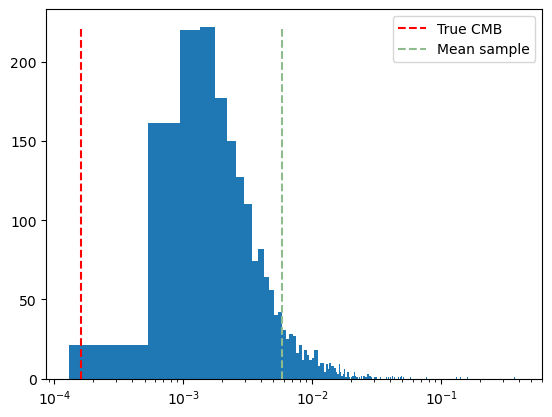

In [139]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    nstokes_select = 1
    ell_select = 0
    burnin = 0
    selection = all_cell_samples[burnin:,nstokes_select,ell_select]

    n_sigma = 3
    transformed_samples = np.abs(selection - selection.mean())/(selection.std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_r = np.round(selection[cond].mean(), decimals=5)
    std_r = np.round(selection[cond].std(), decimals=5)

    # hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins='rice')
    hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins=1000)
    plt.plot([c_ell_true_CMB[nstokes_select,ell_select],c_ell_true_CMB[nstokes_select,ell_select]], [0,hist_nb.max()], 'r--', label='True CMB')
    plt.plot([selection.mean(),selection.mean()], [0,hist_nb.max()], '--', color='darkseagreen', label='Mean sample')
    plt.xscale('log')
    # (all_cell_samples
    plt.legend()
    plt.show()

In [111]:
all_cell_samples[0,:,0], c_ell_true_CMB[:,0]

(array([0.03358429, 0.00016183, 0.        ]),
 array([0.03358429, 0.00016183, 0.        ]))

In [119]:
all_cell_samples[:,correl,ell_to_probe]

array([0.00016183, 0.01295151, 0.00825031, ..., 0.00088483, 0.0007775 ,
       0.00378587])

In [125]:
all_cell_samples[:,correl,ell_to_probe]

array([0.00016183, 0.01295151, 0.00825031, ..., 0.00088483, 0.0007775 ,
       0.00378587])

In [140]:
all_cell_samples.shape

(2001, 3, 127)

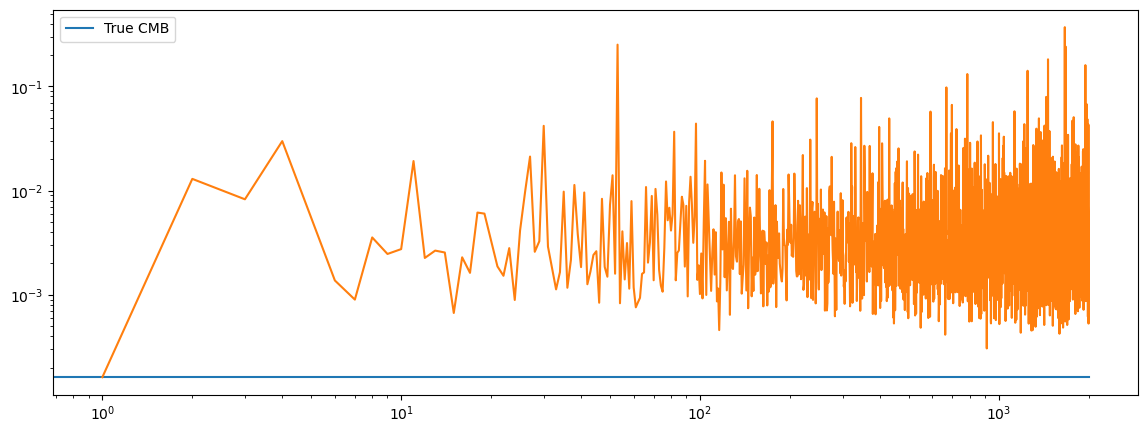

In [149]:
ell_to_probe = 0
correl = 1

plt.figure(figsize=(14,5))
plt.plot([-1,MICMAC_sampler_obj.number_iterations_sampling+1], [c_ell_true_CMB[correl,ell_to_probe],c_ell_true_CMB[correl,ell_to_probe]], label='True CMB')

plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1)+1, all_cell_samples[:,correl,ell_to_probe])

plt.loglog()
# plt.ylim(ymin=0.00015, ymax=0.00017)
plt.legend()
plt.show()


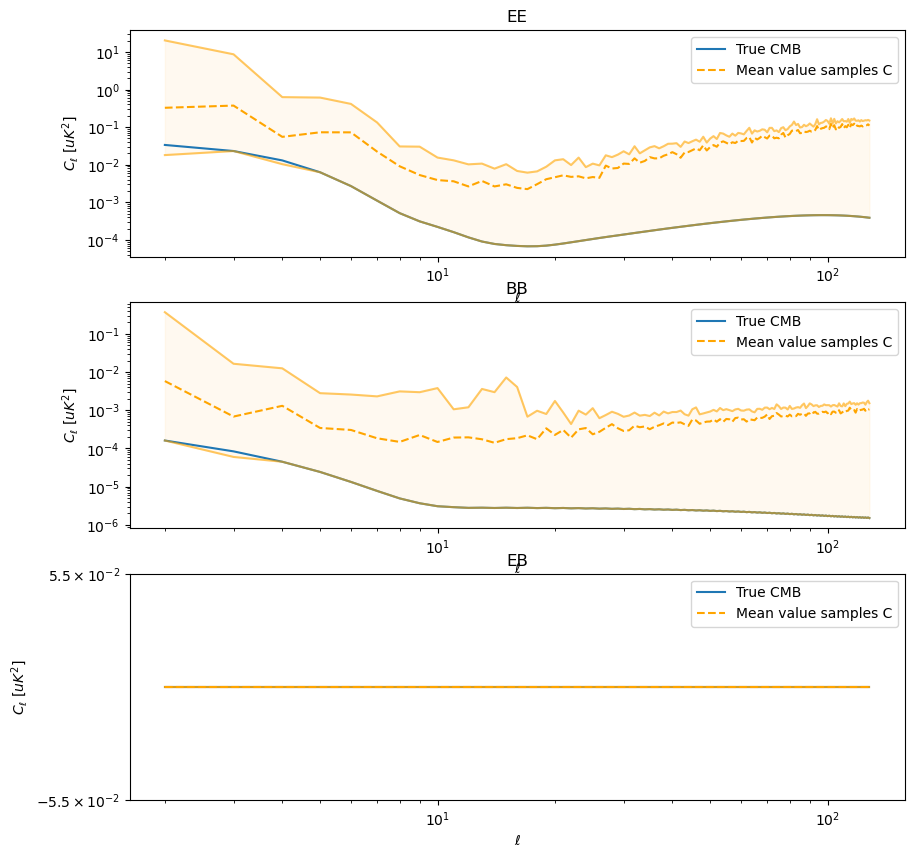

In [105]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    dict_color = {'fill': 'moccasin', 'border': 'orange'}
    c_ell_mean = np.mean(all_cell_samples, axis=0)
    # c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
    # c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

    list_correl = ['EE', 'BB', 'EB']

    ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
    # factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
    factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2))
    # factor = ell_arange*(ell_arange+1)/(2*np.pi)
    plt.figure(figsize=(10,10))
    for j in range(number_correl_to_plot):
        plt.subplot(311+j)
        plt.title(list_correl[j])

        plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
        plt.plot(ell_arange, c_ell_mean[j], '--', color=dict_color['border'], label='Mean value samples C')
        
        curve = c_ell_mean[j]
        std_curve = np.std(all_cell_samples[:,j,...], axis=0)
        plt.fill_between(ell_arange, np.min(all_cell_samples[:,j,...],axis=0), np.max(all_cell_samples[:,j,...],axis=0), color=dict_color['fill'], alpha=0.2)
        plt.plot(ell_arange, np.min(all_cell_samples[:,j,...],axis=0), color=dict_color['border'], alpha=0.6)
        plt.plot(ell_arange, np.max(all_cell_samples[:,j,...],axis=0), color=dict_color['border'], alpha=0.6)
        if j < MICMAC_sampler_obj.nstokes:
            plt.loglog()
        else:
            plt.xscale('log')
            plt.yscale('symlog')
        # plt.loglog()
        plt.legend()
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
    plt.show()

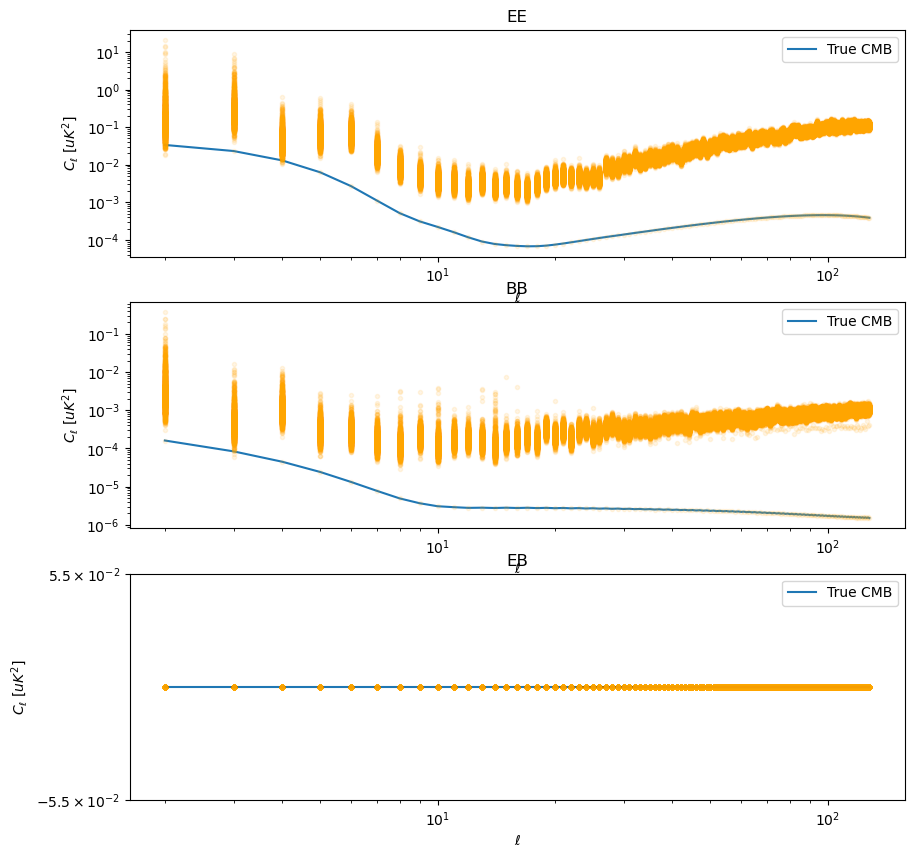

In [73]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    dict_color = {'fill': 'moccasin', 'border': 'orange'}
    # c_ell_mean = np.mean(all_cell_samples, axis=0)
    # c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
    # c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

    list_correl = ['EE', 'BB', 'EB']

    ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
    # factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
    plt.figure(figsize=(10,10))
    for j in range(number_correl_to_plot):
        plt.subplot(311+j)
        plt.title(list_correl[j])

        plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
        for ell in range(c_ell_mean.shape[1]):
            plt.plot(ell_arange[ell]*np.ones(MICMAC_sampler_obj.number_iterations_sampling+1), all_cell_samples[:,j,ell], '.', color=dict_color['border'], alpha=0.1)
        # plt.plot(ell_arange, all_cell_samples[:,j,:].T, '.', color=dict_color['border'], label='Mean value samples C')

        if j < MICMAC_sampler_obj.nstokes:
            plt.loglog()
        else:
            plt.xscale('log')
            plt.yscale('symlog')
        # plt.loglog()
        plt.legend()
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
    plt.show()

In [74]:
# all_r_samples_2 = np.copy(all_r_samples)

In [75]:
# all_r_samples = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1)
# all_r_samples[0] = all_r_samples_2[0]
# all_r_samples[1:] = all_r_samples_2[9:]
# all_r_samples

# Studying $r$

In [76]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    plt.figure(figsize=(14,4))
    # mean_r = np.round(all_r_samples.mean(), decimals=5)
    # std_r = np.round(all_r_samples.std(), decimals=5)
    n_sigma = 3
    transformed_samples = np.abs(all_r_samples - all_r_samples.mean())/(all_r_samples.std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
    std_r = np.round(all_r_samples[cond].std(), decimals=5)

    plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")
    plt.subplot(121)
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples, label='r samples')
    plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
    if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
        plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples.min(),all_r_samples.max()], color='black',alpha=.2)
    plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel('$r$ sample')
    plt.title('Complete path of $r$')
    plt.legend()

    plt.subplot(122)
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples, label='r samples')
    plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
    if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
        plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples.min(),all_r_samples.max()], '--', color='black')
    # plt.yscale('symlog')
    plt.xlabel("Iterations")
    plt.ylabel('$r$ sample')
    plt.title('Zoom around true value of $r$')
    plt.legend()
    # plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
    plt.show()

In [77]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    n_sigma = 3
    transformed_samples = np.abs(all_r_samples - all_r_samples.mean())/(all_r_samples.std()) #< n_sigma
    old_cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    new_cond = np.logical_and(old_cond, np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > 2000)
    mean_r = np.round(all_r_samples[new_cond].mean(), decimals=5)
    std_r = np.round(all_r_samples[new_cond].std(), decimals=5)

    print("r estimates post burn-in: {} +/- {}".format(mean_r, std_r))

In [78]:
all_mixing_matrix = np.zeros((MICMAC_sampler_obj.number_iterations_sampling+1,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_components))

all_mixing_matrix[:,:,0] = mixing_matrix_sampled[:,0]
all_mixing_matrix[:,0,:] = mixing_matrix_sampled[0,:]
all_mixing_matrix[:,-1,:] = mixing_matrix_sampled[-1,:]

all_mixing_matrix[:,1:-1,1:] = all_params_mixing_matrix_samples

mixing_matrix_obj.update_params(init_params)
mixing_matrix_sampled = mixing_matrix_obj.get_B()
BtinvNB_true = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)

true_N_c = BtinvNB_true[0,0]
cl_noise_harm_0 = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin]

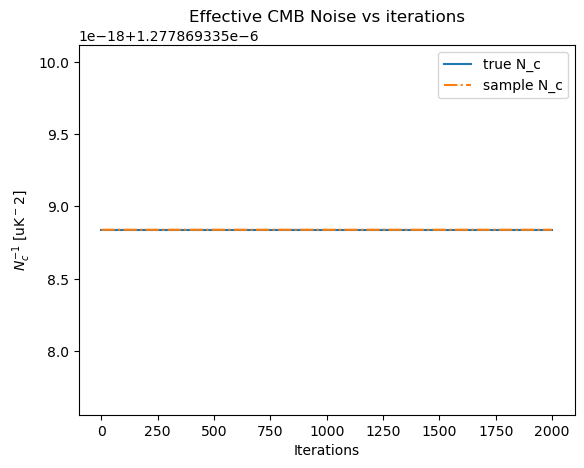

In [79]:
# all_N_c = jnp.linalg.pinv(jnp.einsum("ifc,fh,ihd->icd", B, MICMAC_sampler_obj.freq_inverse_noise, B))[:,0,0]

all_inv_N_c = jnp.linalg.pinv(jnp.einsum("ifc,fh,ihd->icd", all_mixing_matrix, MICMAC_sampler_obj.freq_inverse_noise, all_mixing_matrix))[:,0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
plt.title('Effective CMB Noise vs iterations')
# plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [true_N_c,true_N_c], label='true N_c')
plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [cl_noise_harm_0,cl_noise_harm_0], label='true N_c')
plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_inv_N_c, '-.', label='sample N_c')

plt.xlabel('Iterations')
plt.ylabel('$N_c^{-1}$ [uK$^-2$]')
# plt.loglog()
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

In [80]:
# initial_freq_maps_only_B = np.copy(initial_freq_maps)
# c_ell_select_only_Bmodes = np.zeros((6,lmax+1))
# c_ell_select_only_Bmodes[2,lmin:] = 1
# red_cov_select_Bmodes = micmac.get_reduced_matrix_from_c_ell(c_ell_select_only_Bmodes[indices_polar,...])[lmin:,...]
# for freq in range(number_frequencies):
#     initial_freq_maps_only_B[freq] = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(initial_freq_maps[freq]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

# input_cmb_maps_only_B = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(input_cmb_maps[0]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

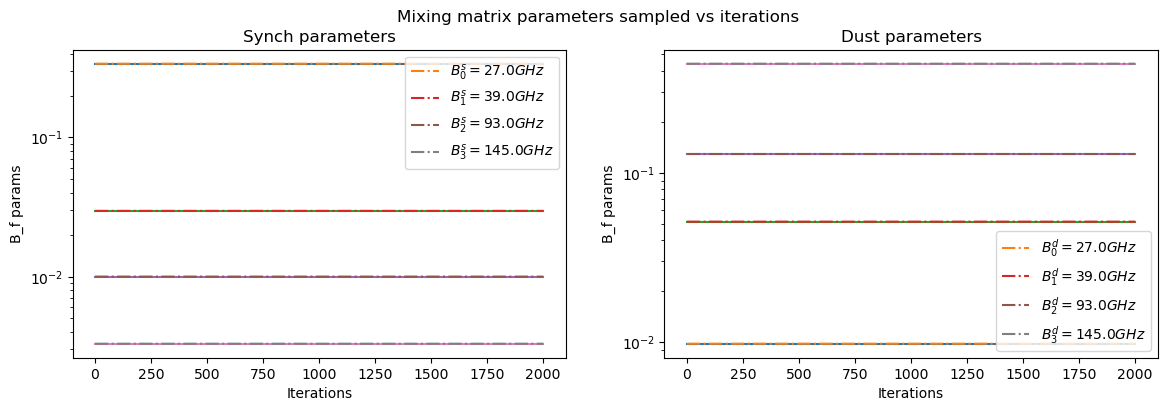

In [81]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = instrument['frequency'][1:-1]
all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

frequency_array = np.array(instrument['frequency'])


plt.figure(figsize=(14,4))
plt.suptitle('Mixing matrix parameters sampled vs iterations')
plt.subplot(121)
plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('B_f params')

plt.subplot(122)
plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('B_f params')
plt.show()


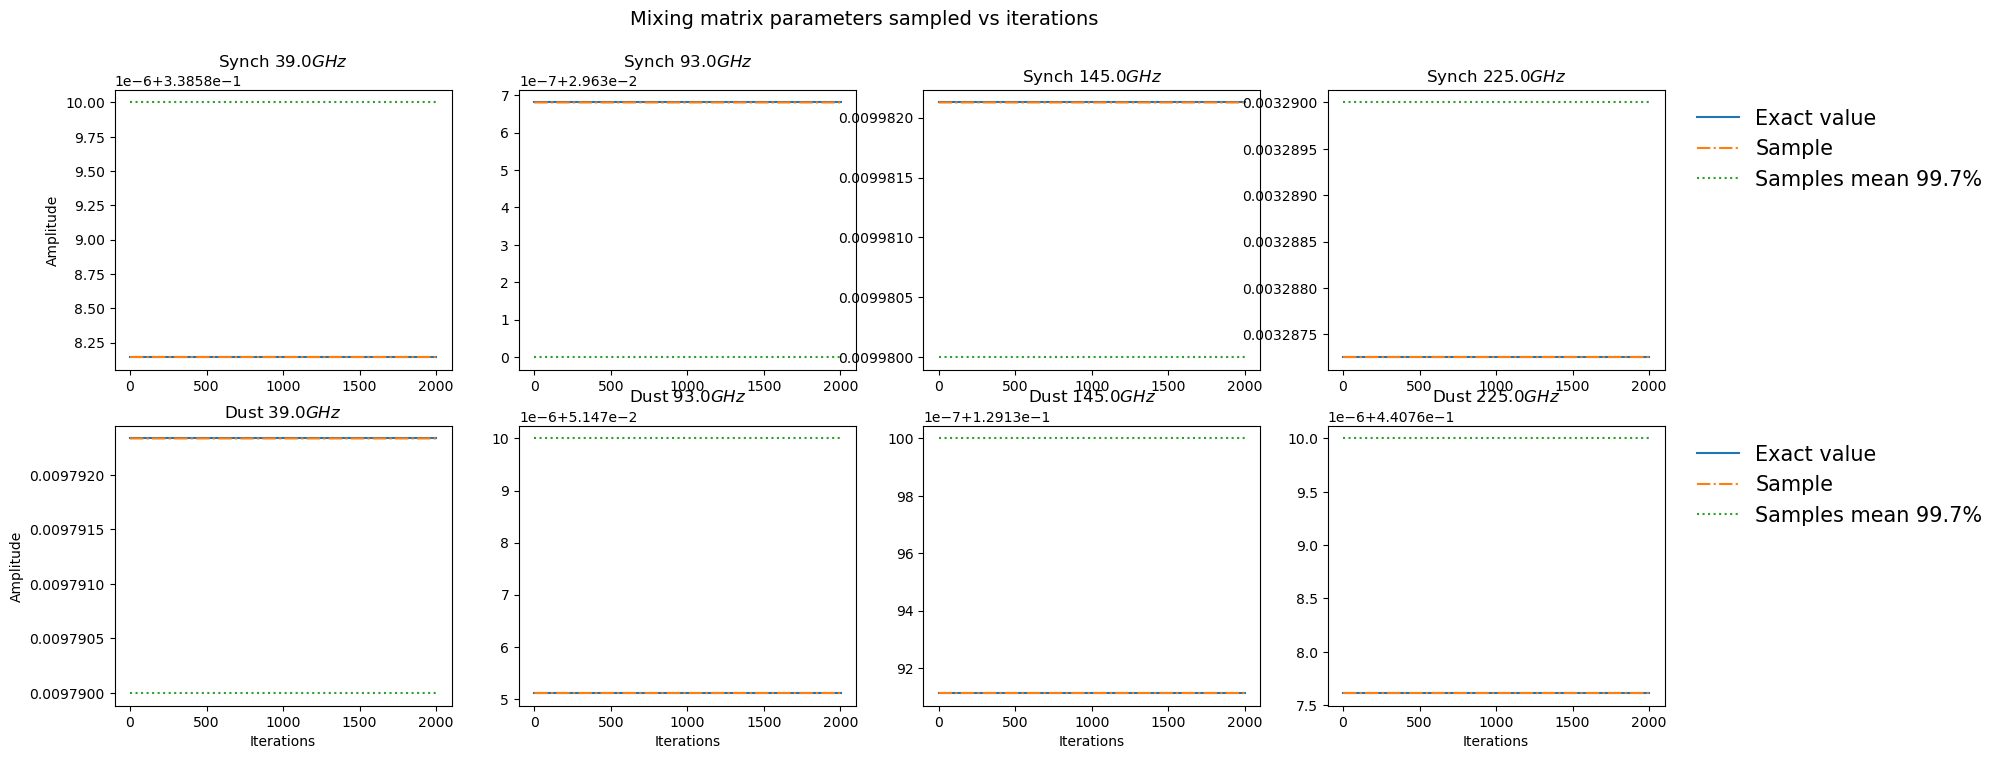

In [82]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

frequency_array = np.array(instrument['frequency'])


plt.figure(figsize=(20,8))
plt.suptitle('Mixing matrix parameters sampled vs iterations', fontsize=14)
# plt.subplot(121)

for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.subplot(201+len(frequency_Bf)*10+i)
    plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
    
    n_sigma = 3
    transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_synch[:,i].mean()
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

    # plt.yscale('log')
    # plt.xlabel('Iterations')
    if i == 0:
        plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()


# plt.subplot(122)
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
    plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

    n_sigma = 3
    transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_dust[:,i].mean()
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
    # plt.yscale('log')
    plt.xlabel('Iterations')
    if i == 0:
        plt.ylabel('Amplitude')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
# plt.loglog()

plt.show()


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_3773/1318878753.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_3773/1318878753.py:29: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


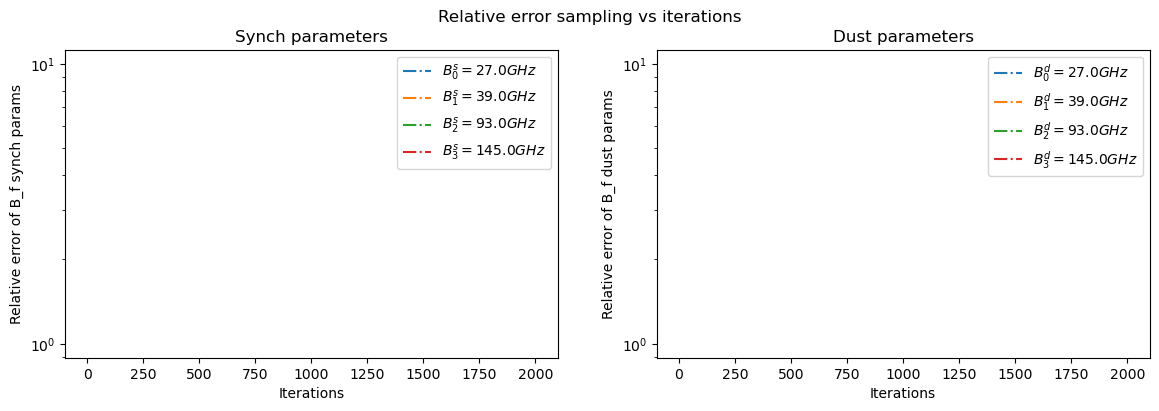

In [83]:
all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

plt.figure(figsize=(14,4))
plt.suptitle('Relative error sampling vs iterations')
plt.subplot(121)
plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i,0])/init_params[i,0])
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
    plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f synch params')

plt.subplot(122)
plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i,1])/init_params[i,1])
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
    plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f dust params')
plt.show()


In [84]:
all_params_mixing_matrix_samples.shape

(2001, 4, 2)

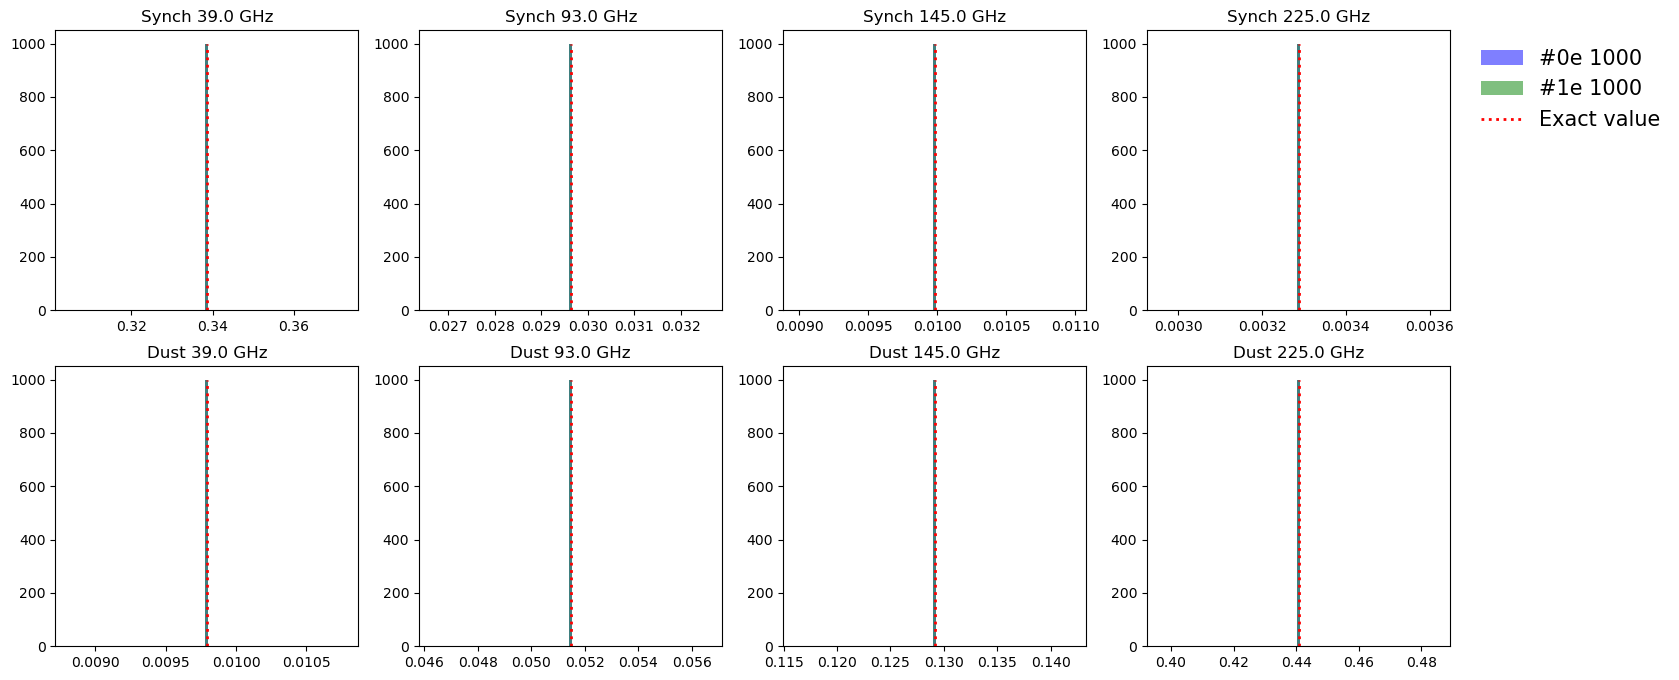

In [85]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']

plt.figure(figsize=(18,8))

for i in range(len(frequency_Bf)):
    plt.subplot(201+len(frequency_Bf)*10+i)
    plt.title((f'Synch {frequency_Bf[i]} GHz'))
    if all_params_mixing_matrix_samples[:,i,0].min() == all_params_mixing_matrix_samples[:,i,0].max():
        min_value = all_params_mixing_matrix_samples[:,i,0].min()*.9
        max_value = all_params_mixing_matrix_samples[:,i,0].max()*1.1
    else:
        min_value = all_params_mixing_matrix_samples[:,i,0].min()
        max_value = all_params_mixing_matrix_samples[:,i,0].max()
    bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

    max_height = 0
    for j in range(num_iter_1000):
        heights, _, _ = plt.hist(all_params_mixing_matrix_samples[j*1000:(j+1)*1000,i,0], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
        max_height = max(max_height, heights.max())
    # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
    plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


for i in range(len(frequency_Bf)):
    plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
    plt.title((f'Dust {frequency_Bf[i]} GHz'))
    if all_params_mixing_matrix_samples[:,i,1].min() == all_params_mixing_matrix_samples[:,i,1].max():
        min_value = all_params_mixing_matrix_samples[:,i,1].min()*.9
        max_value = all_params_mixing_matrix_samples[:,i,1].max()*1.1
    else:
        min_value = all_params_mixing_matrix_samples[:,i,1].min()
        max_value = all_params_mixing_matrix_samples[:,i,1].max()
    bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

    max_height = 0
    for j in range(num_iter_1000):
        heights, _, _ = plt.hist(all_params_mixing_matrix_samples[j*1000:(j+1)*1000,i,1], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
        max_height = max(max_height, heights.max())

    # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
    plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
# plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

plt.show()


In [86]:
final_params = all_params_mixing_matrix_samples[-1]
final_params = all_params_mixing_matrix_samples.mean(axis=0)
# final_params = all_params_mixing_matrix_samples[1000:].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[0]
# final_params = all_params_mixing_matrix_samples[:1000].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[1000]
# final_params = all_params_mixing_matrix_samples[:num_sample_AM].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[num_sample_AM:].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[2000:].mean(axis=0)

mixing_matrix_obj.update_params(final_params)
final_mixing_matrix = mixing_matrix_obj.get_B()

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, initial_freq_maps, jax_use=False)[0, :, :]

mixing_matrix_obj.update_params(init_params)
init_mixing_matrix_obj = mixing_matrix_obj.get_B()
recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, initial_freq_maps, jax_use=False)[0, :, :]

residuals_Wd = recovered_CMB_Wd - input_cmb_maps[0]
residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[0]

recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


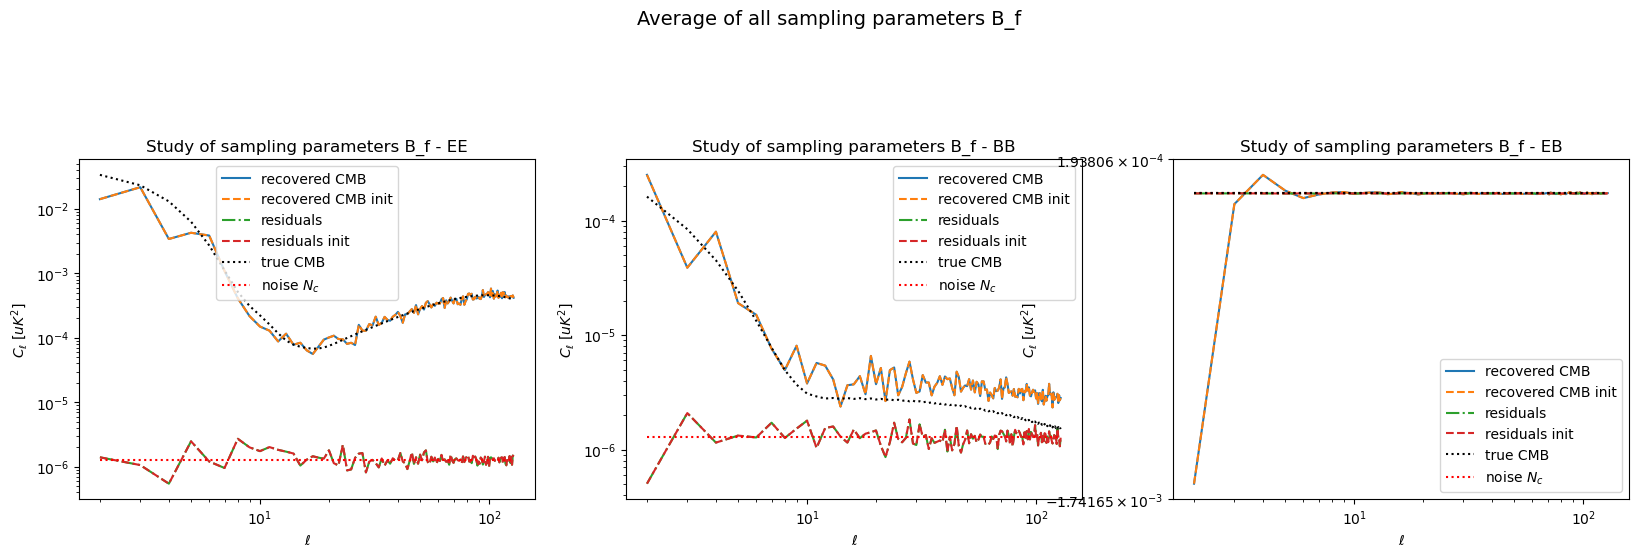

In [87]:
plt.figure(figsize=(20,15))
list_correl = ['EE', 'BB', 'EB']
plt.suptitle('Average of all sampling parameters B_f', fontsize=14)
number_subplots_convention = 331
for i in range(number_correl_to_plot):
    plt.subplot(number_subplots_convention+i)
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

    if i <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
plt.show()

In [88]:
estimated_params = all_params_mixing_matrix_samples[-1000:].mean(axis=0)
estimated_std = all_params_mixing_matrix_samples[-1000:].std(axis=0)

Fisher_uncertainty = np.diag(sp.linalg.sqrtm(np.linalg.pinv(Fisher_matrix)))[:-1]

print("Number of iterations", MICMAC_sampler_obj.number_iterations_sampling)
for i in range(estimated_params.shape[0]*2):
    j = i%(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
    k = i//(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
    if i>=MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs:
        print('$B^d$ :', frequency_array[j], 'GHz')
    else:
        print('$B^s$ :', frequency_array[j], 'GHz')
    print('Estimated :', estimated_params[j,k], "+-", estimated_std[j,k], '; Fisher :', Fisher_uncertainty[i])
    print('Init params :', init_params[j,k])

Number of iterations 2000
$B^s$ : 27.0 GHz
Estimated : 0.338588145693734 +- 3.885780586188048e-16 ; Fisher : 0.00012271923509225572
Init params : 0.33858814569373363
$B^s$ : 39.0 GHz
Estimated : 0.029630680864429604 +- 2.0469737016526324e-16 ; Fisher : 4.7298409004903154e-05
Init params : 0.02963068086442981
$B^s$ : 93.0 GHz
Estimated : 0.009982127277307072 +- 1.214306433183765e-17 ; Fisher : 4.440847628279965e-05
Init params : 0.00998212727730706
$B^s$ : 145.0 GHz
Estimated : 0.0032872542990528522 +- 3.8163916471489756e-17 ; Fisher : 5.2354688154349816e-05
Init params : 0.0032872542990528904
$B^d$ : 27.0 GHz
Estimated : 0.009792334998282425 +- 1.491862189340054e-16 ; Fisher : 4.28340683242134e-05
Init params : 0.009792334998282276
$B^d$ : 39.0 GHz
Estimated : 0.05147511339507315 +- 9.298117831235686e-16 ; Fisher : 1.6227076640621494e-05
Init params : 0.05147511339507408
$B^d$ : 93.0 GHz
Estimated : 0.12913911295549604 +- 3.0253577421035516e-15 ; Fisher : 1.5290538379505563e-05
Init pa